# Technical Overview
A regression problem, targeting a continuous variable, using financial(also continuous) features, modeled using Muliple Linear Regression with Lasso selection, Regression Trees with Random Forest Regression selection and GridSearchCV hyperparameter tuning, K-Nearest Neighbor Regression and XGBoost. 

# Business Understanding
In [Public Act 102-0570](https://ilga.gov/legislation/publicacts/fulltext.asp?Name=102-0570), Illinois' General Assembly has commissioned the Illinois Board of Higher Education (IBHE) to offer "specific data-driven criteria and approaches to the General Assembly to adequately, equitably, and stably fund public universities in this State and to evaluate existing funding methods." This Commision on Equitable Public University Funding (CEPUF) coincides with the [A Thriving Illinois: Higher Education Paths to Equity, Sustainability, and Growth] (https://ibhestrategicplan.ibhe.org/IBHE-Strategic-Plan-2021.html) which includes providing "equitable funding so that students can receive the best educational experience and succeed at whichever institution they attend," and funding "institutions sufficiently to achieve student, institutional, and state goals."

This project targets 6-year black bachelors graduation rates for first-time, full-time students-- the typical measure for college student success-- using U.S. public and private university data from the Integrated Postsecondary Education Data System (IPEDS). This project aims to offer data-driven advice on how Illinois' universities might better leverage their financials towards black student success.

# Data Understanding

### Imports

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pyodbc
import matplotlib.pyplot as plt

from functools import reduce

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.dummy import  DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor 

import warnings
warnings.filterwarnings("ignore")

### Retrieval
Data was accessed through [IPEDS](https://nces.ed.gov/ipeds/use-the-data/download-access-database). After downloading 10 years(2009-2020) of their Access database files (.accdb), pyodbc module and SQL query was used to pull financial data (financial data (tables: DRVF, F_F1A, and F_F2) from 1681 public (587) and private (1094) universities (The IPEDS website does offer a [user-friendly query interface](https://nces.ed.gov/ipeds/datacenter/InstitutionList.aspx?goToReportId=1), but only 20 variables could be pulled at a time. Also, make sure the features selected are in the years selected, or an error will occur). 
Here is an example of a query for the target variable for one of the 10 databases:
 
 INSERT RETRIVAL IMAGE

After the queries were saved to csv, they were concatenated into two datafarmes: public and private. 

INSERT CONCATENATE IMAGE

One advantage of IPEDS is that all tables have the same key: 'UNITID,' except for the provisional tables in 2019-2020 (DRVC2019,DRVEF122019,DRVF2019,DRVIC2019, S2019_OC have key:'unitid'; S2019_IS and S2019_NH have key:'UnitiID'), which made joining a breeze. 

### Data

In [10]:
df_private = pd.read_csv("data/private_financials_10.csv").iloc[:, 1:]
df_public = pd.read_csv("data/public_financials_10.csv").iloc[:, 1:]

### Labeling
A csv of school IDs and labels pulled from IPEDs is used as index, but must be added to the dataframe first. Labels for variables were also pulled from the table and variable documentation alongside the acces databases. Labels were transposed over variable names.

In [11]:
#Read school id's
df_ids = pd.read_csv("data/university_ids.csv").iloc[:,0:2]
df_ids.rename(columns={'IPEDS\nUnit ID': 'UNITID', 'Organization or School Name':'School'}, inplace=True)
private_ids = [df_ids, df_private]
public_ids = [df_ids, df_public]
#Add school names
df_private= reduce(lambda x, y: pd.merge(x, y, on = 'UNITID'), private_ids)
df_public= reduce(lambda x, y: pd.merge(x, y, on = 'UNITID'), public_ids)
#Set Index
df_private.set_index(['School'], inplace=True)
df_public.set_index(['School'], inplace=True)

### Limitations
Because IPEDS is institutional in focus, it does not track specific cohorts of students; thus, financial information for individual students, including financial aid, loan default information, and family income. 

### Data Cleaning

In [12]:
#Drop schools if they do not have target
df_private = df_private[~df_private['Target'].isna()]
df_public = df_public[~df_public['Target'].isna()]

In [13]:
#drop 40% missing columns
num_pr= len(df_private) * .40
res = df_private.columns[df_private.isnull().sum() > num_pr]
df_private.drop(res, inplace=True, axis=1)

num_pub = len(df_public) * .40
res2 = df_public.columns[df_public.isnull().sum() > num_pub]
df_public.drop(res2, inplace=True, axis=1)

### EDA

In [14]:
#Slicing Illinois Private Schools
illinois_private = pd.read_csv("data/IL_private_schools.csv")
il_ids_pr=illinois_private["UnitID"].tolist()
illinois_pr = df_private[df_private["UNITID"].isin(il_ids_pr)]

In [16]:
#Slicing Illinois Public Schools
illinois_public = pd.read_csv("data/IL_public_schools.csv")
il_ids_pub=illinois_public["UnitID"].tolist()
illinois_pub = df_public[df_public["UNITID"].isin(il_ids_pub)]

#### Groupby school, year, and school and year

In [17]:
private_schools= df_private.groupby("UNITID").mean()
private_byyear = df_private.groupby('Year').mean()
private_school_and_year = df_private.groupby(['UNITID', 'Year']).mean()

In [18]:
public_schools= df_public.groupby("UNITID").mean()
public_byyear = df_public.groupby('Year').mean()
public_school_and_year = df_public.groupby(['UNITID', 'Year']).mean()

In [19]:
il_pr_schools= illinois_pr.groupby("UNITID").mean()
il_pr_byyear = illinois_pr.groupby('Year').mean()
il_pr_school_and_year = illinois_pr.groupby(['UNITID', 'Year']).mean()

In [20]:
il_pub_schools= illinois_pub.groupby("UNITID").mean()
il_pub_byyear = illinois_pub.groupby('Year').mean()
il_pub_school_and_year = illinois_pub.groupby(['UNITID', 'Year']).mean()

In [21]:
#schools graduating less than 25% of black students and p
# ercentage of all schools
list = [private_schools, public_schools, illinois_pr, illinois_pub]
for i in list: 
    length = len(i)
    print('Total schools less than a quarter graduating:')
    print(len(i[i['Target'] < 25]))
    print("Percentage of low graduating schools: ")
    print(len(i[i['Target'] < 25])/ length)

Total schools less than a quarter graduating:
224
Percentage of low graduating schools: 
0.20475319926873858
Total schools less than a quarter graduating:
144
Percentage of low graduating schools: 
0.2453151618398637
Total schools less than a quarter graduating:
98
Percentage of low graduating schools: 
0.21585903083700442
Total schools less than a quarter graduating:
23
Percentage of low graduating schools: 
0.20909090909090908


In [22]:
#schools graduating black students above national average
# and percentage of all schools
list = [private_schools, public_schools, illinois_pr, illinois_pub]
for i in list: 
    length = len(i)
    print('Total Schools exceed national avaeage GR:')
    print(len(i[i['Target'] > 60 ]))
    print('Percentage exceeding:')
    print(len(i[i['Target'] > 60])/ length)

Total Schools exceed national avaeage GR:
236
Percentage exceeding:
0.21572212065813529
Total Schools exceed national avaeage GR:
72
Percentage exceeding:
0.12265758091993186
Total Schools exceed national avaeage GR:
96
Percentage exceeding:
0.21145374449339208
Total Schools exceed national avaeage GR:
10
Percentage exceeding:
0.09090909090909091


### Illinois schools Black Graduation Rates

In [53]:
illinois_pr['Target']

School
Augustana College (IL)    69.0
Augustana College (IL)    57.0
Augustana College (IL)    65.0
Augustana College (IL)    55.0
Augustana College (IL)    68.0
                          ... 
Wheaton College           90.0
Wheaton College           58.0
Wheaton College           95.0
Wheaton College           87.0
Wheaton College           75.0
Name: Target, Length: 454, dtype: float64

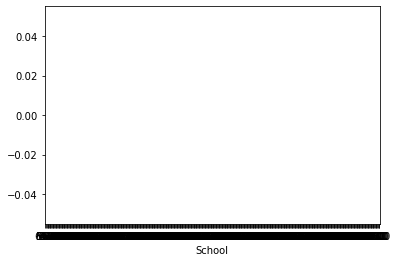

In [23]:
y =illinois_pr['Target'].values
X = illinois_pr['Target'].index
sns.barplot(X,y, order=y);

In [63]:
il_pub_schools['Target']

UNITID
144005.0    16.0
144892.0    43.5
145600.0    42.1
145637.0    73.4
145813.0    50.5
147703.0    29.9
147776.0     8.2
148654.0    44.9
149222.0    29.0
149231.0    31.3
149772.0    38.7
Name: Target, dtype: float64

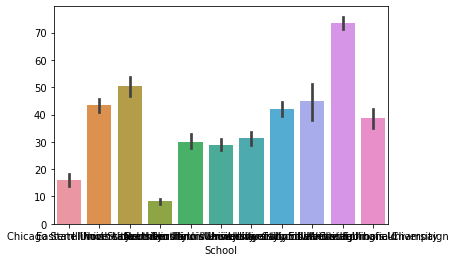

In [24]:
y =illinois_pub['Target'].values
X = illinois_pub['Target'].index
sns.barplot(X,y);

### Black Graduation Rates over time

In [64]:
public_byyear['Target']

Year
2010    36.726103
2011    36.886029
2012    37.171790
2013    36.989286
2014    39.160714
2015    38.433333
2016    38.778746
2017    38.706806
2018    40.986111
2019    41.930915
Name: Target, dtype: float64

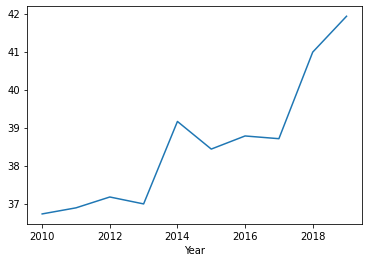

In [25]:
y =public_byyear['Target'].values
X = public_byyear['Target'].index
sns.lineplot(X,y);

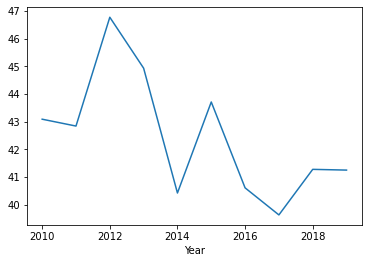

In [26]:
y =il_pr_byyear['Target'].values
X = il_pr_byyear['Target'].index
sns.lineplot(X,y);

In [56]:
il_pub_byyear['Target']

Year
2010    39.545455
2011    37.363636
2012    34.636364
2013    35.909091
2014    38.909091
2015    37.272727
2016    36.363636
2017    37.727273
2018    36.000000
2019    36.727273
Name: Target, dtype: float64

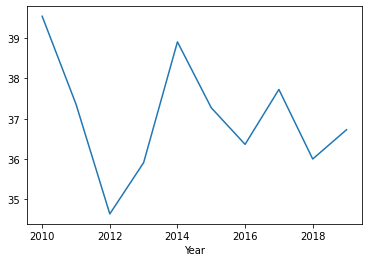

In [27]:
y =il_pub_byyear['Target'].values
X = il_pub_byyear['Target'].index
sns.lineplot(X,y);

### Train, Test, Split

In [28]:
#private
y_pr = df_private['Target']
X_pr = df_private.drop(columns = ['Target'], axis = 1)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr,
                                             y_pr, random_state = 42)
#and for public
y_pub = df_public['Target']
X_pub = df_public.drop(columns = ['Target'], axis = 1)
X_train_pub, X_test_pub, y_train_pub, y_test_pub = train_test_split(X_pub, 
                                            y_pub, random_state = 42)


# Methods

### Pipeline

In [29]:
pipeline = Pipeline(steps=[
    ('si', SimpleImputer()),
    ('ss', StandardScaler())
])

### Baseline

In [30]:
dummy_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('dummy', DummyRegressor())
])
#Fit model
dummy_pr.fit(X_train_pr, y_train_pr)

#Grab predictions
dummy_pr_preds= dummy_pr.predict(X_train_pr)

#R^2 score
dummy_pr_score = dummy_pr.score(X_train_pr, y_train_pr)
print("Dummy PR R^2 Training Score:" + str(dummy_pr_score))

#Run a cross validation to test for overfitting
dummy_pr_v= np.mean(cross_val_score(dummy_pr, X_train_pr, y_train_pr, cv=5))
print("Dummy PR R^2 Validation Score:" + str(dummy_pr_v))

#RMSE
dummy_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,dummy_pr_preds))
print('Dummy PR Root Mean Squared Error:' + str(dummy_pr_rmse))

Dummy PR R^2 Training Score:0.0
Dummy PR R^2 Validation Score:-0.0005092556664282544
Dummy PR Root Mean Squared Error:26.991139559568747


In [31]:
#Public
dummy_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('dummy', DummyRegressor())
])
dummy_pub.fit(X_train_pub, y_train_pub)
dummy_pub_preds =dummy_pub.predict(X_train_pub)
dummy_pub_score = dummy_pub.score(X_train_pub, y_train_pub)
print("Dummy PUB R^2 Training Score:" + str(dummy_pub_score))
dummy_pub_v= np.mean(cross_val_score(dummy_pr, X_train_pub, y_train_pub, cv=5))
print("Dummy PUB R^2 Validation Score:" + str(dummy_pub_v))
dummy_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,dummy_pub_preds))
print('Dummy PUB Root Mean Squared Error:' +str(dummy_pub_rmse))

Dummy PUB R^2 Training Score:0.0
Dummy PUB R^2 Validation Score:-0.000665679256072016
Dummy PUB Root Mean Squared Error:20.67988980644399


### Multiple Linear Regression with Lasso

In [32]:
#Private
lr_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('selection', SelectFromModel(Lasso())),
    ('ols', LinearRegression(normalize=True))
])
lr_pr.fit(X_train_pr, y_train_pr)
y_pred_lr_pr = lr_pr.predict(X_train_pr)
lr_pr_score=lr_pr.score(X_train_pr, y_train_pr)
print("LR PR R^2 Training Score:" + str(lr_pr_score))
lr_pr_v=scores_pr= np.mean(cross_val_score(lr_pr, X_train_pr, y_train_pr, cv=5))
print("LR PR R^2 Validation Score:" + str(lr_pr_v))
lr_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,y_pred_lr_pr))
print('LR PR Root Mean Squared Error:' +str(lr_pr_rmse))

LR PR R^2 Training Score:0.3499213144148585
LR PR R^2 Validation Score:0.34399500980911224
LR PR Root Mean Squared Error:21.76226949838226


In [33]:
#for public
lr_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('selection', SelectFromModel(Lasso())),
    ('ols', LinearRegression(normalize=True))
])
lr_pub.fit(X_train_pub, y_train_pub)
y_pred_lr_pub = lr_pub.predict(X_train_pub)
lr_pub_score= lr_pub.score(X_train_pub, y_train_pub)
print("LR PUB R^2 Score:" + str(lr_pub_score))
lr_pub_v = np.mean(cross_val_score(lr_pub, X_train_pub, y_train_pub, cv=5))
print("LR PUB R^2 Validation Score:" + str(lr_pub_v))
lr_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,y_pred_lr_pub))
print('LR PUB Root Mean Squared Error:' + str(lr_pub_rmse))


LR PUB R^2 Score:0.3821655228453187
LR PUB R^2 Validation Score:0.36840659917478996
LR PUB Root Mean Squared Error:16.254899552578653


### Decision Tree 

### Random Forest

In [34]:
#Private
forest_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('forest', RandomForestRegressor(max_depth=4, max_features=24, min_samples_leaf=.1, min_samples_split=.1,
     n_estimators=100, random_state=42))
])
forest_pr.fit(X_train_pr, y_train_pr)
forest_pr_preds =forest_pr.predict(X_train_pr)
forest_pr_score= forest_pr.score(X_train_pr, y_train_pr)
print("Forest PR R^2:" + str(forest_pr_score))
forest_pr_v = np.mean(cross_val_score(forest_pr, X_train_pr, y_train_pr, cv=5))
print("Forest PR R^2 Validation Score:" + str(forest_pr_v))
forest_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,forest_pr_preds))
print('Forest PR Root Mean Squared Error:'+ str(forest_pr_rmse))

Forest PR R^2:0.3680816169914326
Forest PR R^2 Validation Score:0.35893177920496877
Forest PR Root Mean Squared Error:21.456145990444195


In [35]:
#Public
forest_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('forest', RandomForestRegressor(max_depth=5,max_features=27 ,min_samples_leaf=.1, min_samples_split=.1,
    n_estimators=100, random_state=42))
])
forest_pub.fit(X_train_pub, y_train_pub) 
forest_pub_preds =forest_pub.predict(X_train_pub)
forest_pub_score= forest_pub.score(X_train_pub, y_train_pub)
print("Forest PUB R^2:" + str(forest_pub_score))
forest_pub_v = np.mean(cross_val_score(forest_pub, X_train_pub, y_train_pub, cv=5))
print("Forest PUB R^2 Validation Score:" + str(forest_pub_v))
forest_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,forest_pub_preds))
print('Forest PUB Root Mean Squared Error:' + str(forest_pub_rmse))

Forest PUB R^2:0.36060939093082245
Forest PUB R^2 Validation Score:0.3507133886132858
Forest PUB Root Mean Squared Error:16.536033633541287


### KNN

In [36]:
#Private
neigh_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('neigh', KNeighborsRegressor(n_neighbors=2))
])
neigh_pr.fit(X_train_pr, y_train_pr)
neigh_pr_preds=neigh_pr.predict(X_train_pr)
neigh_pr_score= neigh_pr.score(X_train_pr, y_train_pr)
print("KNN PR R^2:" + str(neigh_pr_score))
neigh_pr_v = np.mean(cross_val_score(neigh_pr, X_train_pr, y_train_pr, cv=5))
print("KNN PR R^2 Validation Score:" + str(neigh_pr_v))
neigh_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,neigh_pr_preds))
print('KNN PR Root Mean Squared Error:'+ str(neigh_pr_rmse))

KNN PR R^2:0.7802602112940732
KNN PR R^2 Validation Score:0.31276968191014254
KNN PR Root Mean Squared Error:12.65247745254573


In [37]:
neigh_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('neigh', KNeighborsRegressor(n_neighbors=2))
])
neigh_pub.fit(X_train_pub, y_train_pub)
neigh_pub_preds=neigh_pub.predict(X_train_pub)
neigh_pub_score= neigh_pub.score(X_train_pub, y_train_pub)
print("KNN PUB R^2:" + str(neigh_pub_score))
neigh_pub_v = np.mean(cross_val_score(neigh_pub, X_train_pub, y_train_pub, cv=5))
print("KNN PUB R^2 Validation Score:" + str(neigh_pub_v))
neigh_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,neigh_pub_preds))
print('KNN PUB Root Mean Squared Error:'+ str(neigh_pub_rmse))

KNN PUB R^2:0.836419326788286
KNN PUB R^2 Validation Score:0.48687999340017785
KNN PUB Root Mean Squared Error:8.364003692320534


### XGBoost

In [38]:
#Private
XGB_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('xgb', XGBRegressor(random_state=42, learning_rate=.1, max_depth=6, min_child_weight=2,
    n_estimators=100, subsample=.7))
])
XGB_pr.fit(X_train_pr, y_train_pr)
XGB_pr_preds=XGB_pr.predict(X_train_pr)
XGB_pr_score= XGB_pr.score(X_train_pr, y_train_pr)
print("XGB PR R^2:" + str(XGB_pr_score))
XGB_pr_v = np.mean(cross_val_score(XGB_pr, X_train_pr, y_train_pr, cv=5))
print("XGB PR R^2 Validation Score:" + str(XGB_pr_v))
XGB_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,XGB_pr_preds))
print('XGB PR Root Mean Squared Error:' + str(XGB_pr_rmse))

XGB PR R^2:0.8036059656239407
XGB PR R^2 Validation Score:0.472985538182572
XGB PR Root Mean Squared Error:11.96149234192082


In [39]:
#Public
XGB_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('xgb', XGBRegressor(learning_rate=.1, max_depth=6, min_child_weight=1, 
    subsample=.7, n_estimators=100, random_state=42))
])
XGB_pub.fit(X_train_pub, y_train_pub)
XGB_pub_preds=XGB_pub.predict(X_train_pub)
XGB_pub_score= XGB_pub.score(X_train_pub, y_train_pub)
print("XBG PUB R^2:" + str(XGB_pub_score))
XGB_pub_v = np.mean(cross_val_score(XGB_pub, X_train_pub, y_train_pub, cv=5))
print("XGB PUB R^2 Validation Score:" + str(XGB_pub_v))
XGB_pr_rmse = np.sqrt(mean_squared_error(y_train_pub,XGB_pub_preds))
print('XGB PUB Root Mean Squared Error:' + str(XGB_pr_rmse))

XBG PUB R^2:0.8886172744452246
XGB PUB R^2 Validation Score:0.6060516839486143
XGB PUB Root Mean Squared Error:6.901716894521904


### SelectFromModel Decision Trees

In [40]:
#Private
tree_pr=Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(max_features=24, n_estimators=100, max_depth=7, 
                                    min_samples_split=.1, min_samples_leaf=.1))),
    ('tree', DecisionTreeRegressor(max_depth=4, min_samples_split=.01, min_samples_leaf=.1,
     max_features=24, random_state=42))
])
tree_pr.fit(X_train_pr, y_train_pr)
tree_pr_preds =tree_pr.predict(X_train_pr)
tree_pr_score= tree_pr.score(X_train_pr, y_train_pr)
print("Tree PR R^2:" + str(tree_pr_score))
tree_pr_v = np.mean(cross_val_score(tree_pr, X_train_pr, y_train_pr, cv=5))
print("Tree PR R^2 Validation Score:" + str(tree_pr_v))
tree_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,tree_pr_preds))
print('Tree PR Root Mean Squared Error:' +str(tree_pr_rmse))

Tree PR R^2:0.3854600914296248
Tree PR R^2 Validation Score:0.37342331139561136
Tree PR Root Mean Squared Error:21.15905495300064


In [41]:
tree_pub= Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6))),
    ('tree', DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 0.05, min_samples_split= 0.15,
    max_features=18,random_state=42))
])
tree_pub.fit(X_train_pub, y_train_pub)
tree_pub_preds =tree_pub.predict(X_train_pub)
tree_pub_score= tree_pub.score(X_train_pub, y_train_pub)
print("Tree PUB R^2:" + str(tree_pub_score))
tree_pub_v = np.mean(cross_val_score(tree_pub, X_train_pub, y_train_pub, cv=5))
print("Tree PUB R^2 Validation Score:" + str(tree_pub_v))
tree_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,tree_pub_preds))
print('Tree PUB Root Mean Squared Error:' + str(tree_pub_rmse))

Tree PUB R^2:0.41096300910820016
Tree PUB R^2 Validation Score:0.3670747846390422
Tree PUB Root Mean Squared Error:15.871555960979444


### Separate Trees for plotting

In [42]:
si= SimpleImputer()
X_train_pr_imputed= si.fit_transform(X_train_pr)
X_train_pr_imputed=pd.DataFrame(X_train_pr_imputed, 
    index=X_train_pr.index, columns=X_train_pr.columns)
#feature Selection
sel_pr= SelectFromModel(RandomForestRegressor(max_features=24, n_estimators=100, max_depth=7, 
                                    min_samples_split=.1, min_samples_leaf=.1))
sel_pr.fit(X_train_pr_imputed,y_train_pr)
#get column names
selected_feat_pr= X_train_pr_imputed.columns[(sel_pr.get_support())]
#change index to list
selected_feat_pr = selected_feat_pr.tolist()
#slide dataframe
selected_feat_pr=X_train_pr_imputed[selected_feat_pr]

In [43]:
separate_tree_pr= DecisionTreeRegressor(max_depth=7, min_samples_leaf=.2, min_samples_split=.05,
    max_features = 22, random_state=42)

separate_tree_pr.fit(selected_feat_pr, y_train_pr)
separate_tree_pr_preds =separate_tree_pr.predict(selected_feat_pr)

separate_tree_pr_score= separate_tree_pr.score(selected_feat_pr, y_train_pr)
print("Tree PR R^2:" + str(separate_tree_pr_score))

separate_tree_pr_v = np.mean(cross_val_score(separate_tree_pr, selected_feat_pr, y_train_pr, cv=5))
print("Tree PR R^2 Validation Score:" + str(separate_tree_pr_v))

separate_tree_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,separate_tree_pr_preds))
print('Tree PR Root Mean Squared Error:' +str(separate_tree_pr_rmse))

Tree PR R^2:0.32747149250962604
Tree PR R^2 Validation Score:0.322779293127088
Tree PR Root Mean Squared Error:22.134849315612872


In [44]:
si= SimpleImputer()
X_train_pub_imputed= si.fit_transform(X_train_pub)
X_train_pub_imputed=pd.DataFrame(X_train_pub_imputed, 
    index=X_train_pub.index, columns=X_train_pub.columns)
#feature Selection
sel_pub= SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6, random_state=42))
sel_pub.fit(X_train_pub_imputed, y_train_pub)
selected_feat_pub= X_train_pub_imputed.columns[(sel_pub.get_support())]
selected_feat_pub = selected_feat_pub.tolist()
selected_feat_pub=X_train_pub_imputed[selected_feat_pub]

In [45]:
separate_tree_pub= DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 0.05, min_samples_split= 0.15,
    max_features=14,random_state=42)

separate_tree_pub.fit(selected_feat_pub, y_train_pub)
separate_tree_pub_preds =separate_tree_pub.predict(selected_feat_pub)

separate_tree_pub_score= separate_tree_pub.score(selected_feat_pub, y_train_pub)
print("Tree PUB R^2:" + str(separate_tree_pub_score))

separate_tree_pub_v = np.mean(cross_val_score(separate_tree_pub, selected_feat_pub, y_train_pub, cv=5))
print("Tree PUB R^2 Validation Score:" + str(separate_tree_pub_v))

separate_tree_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,separate_tree_pub_preds))
print('Tree PUB Root Mean Squared Error:' + str(separate_tree_pub_rmse))

Tree PUB R^2:0.4105352114983639
Tree PUB R^2 Validation Score:0.3780604707591819
Tree PUB Root Mean Squared Error:15.877318401585056


# Evaluation

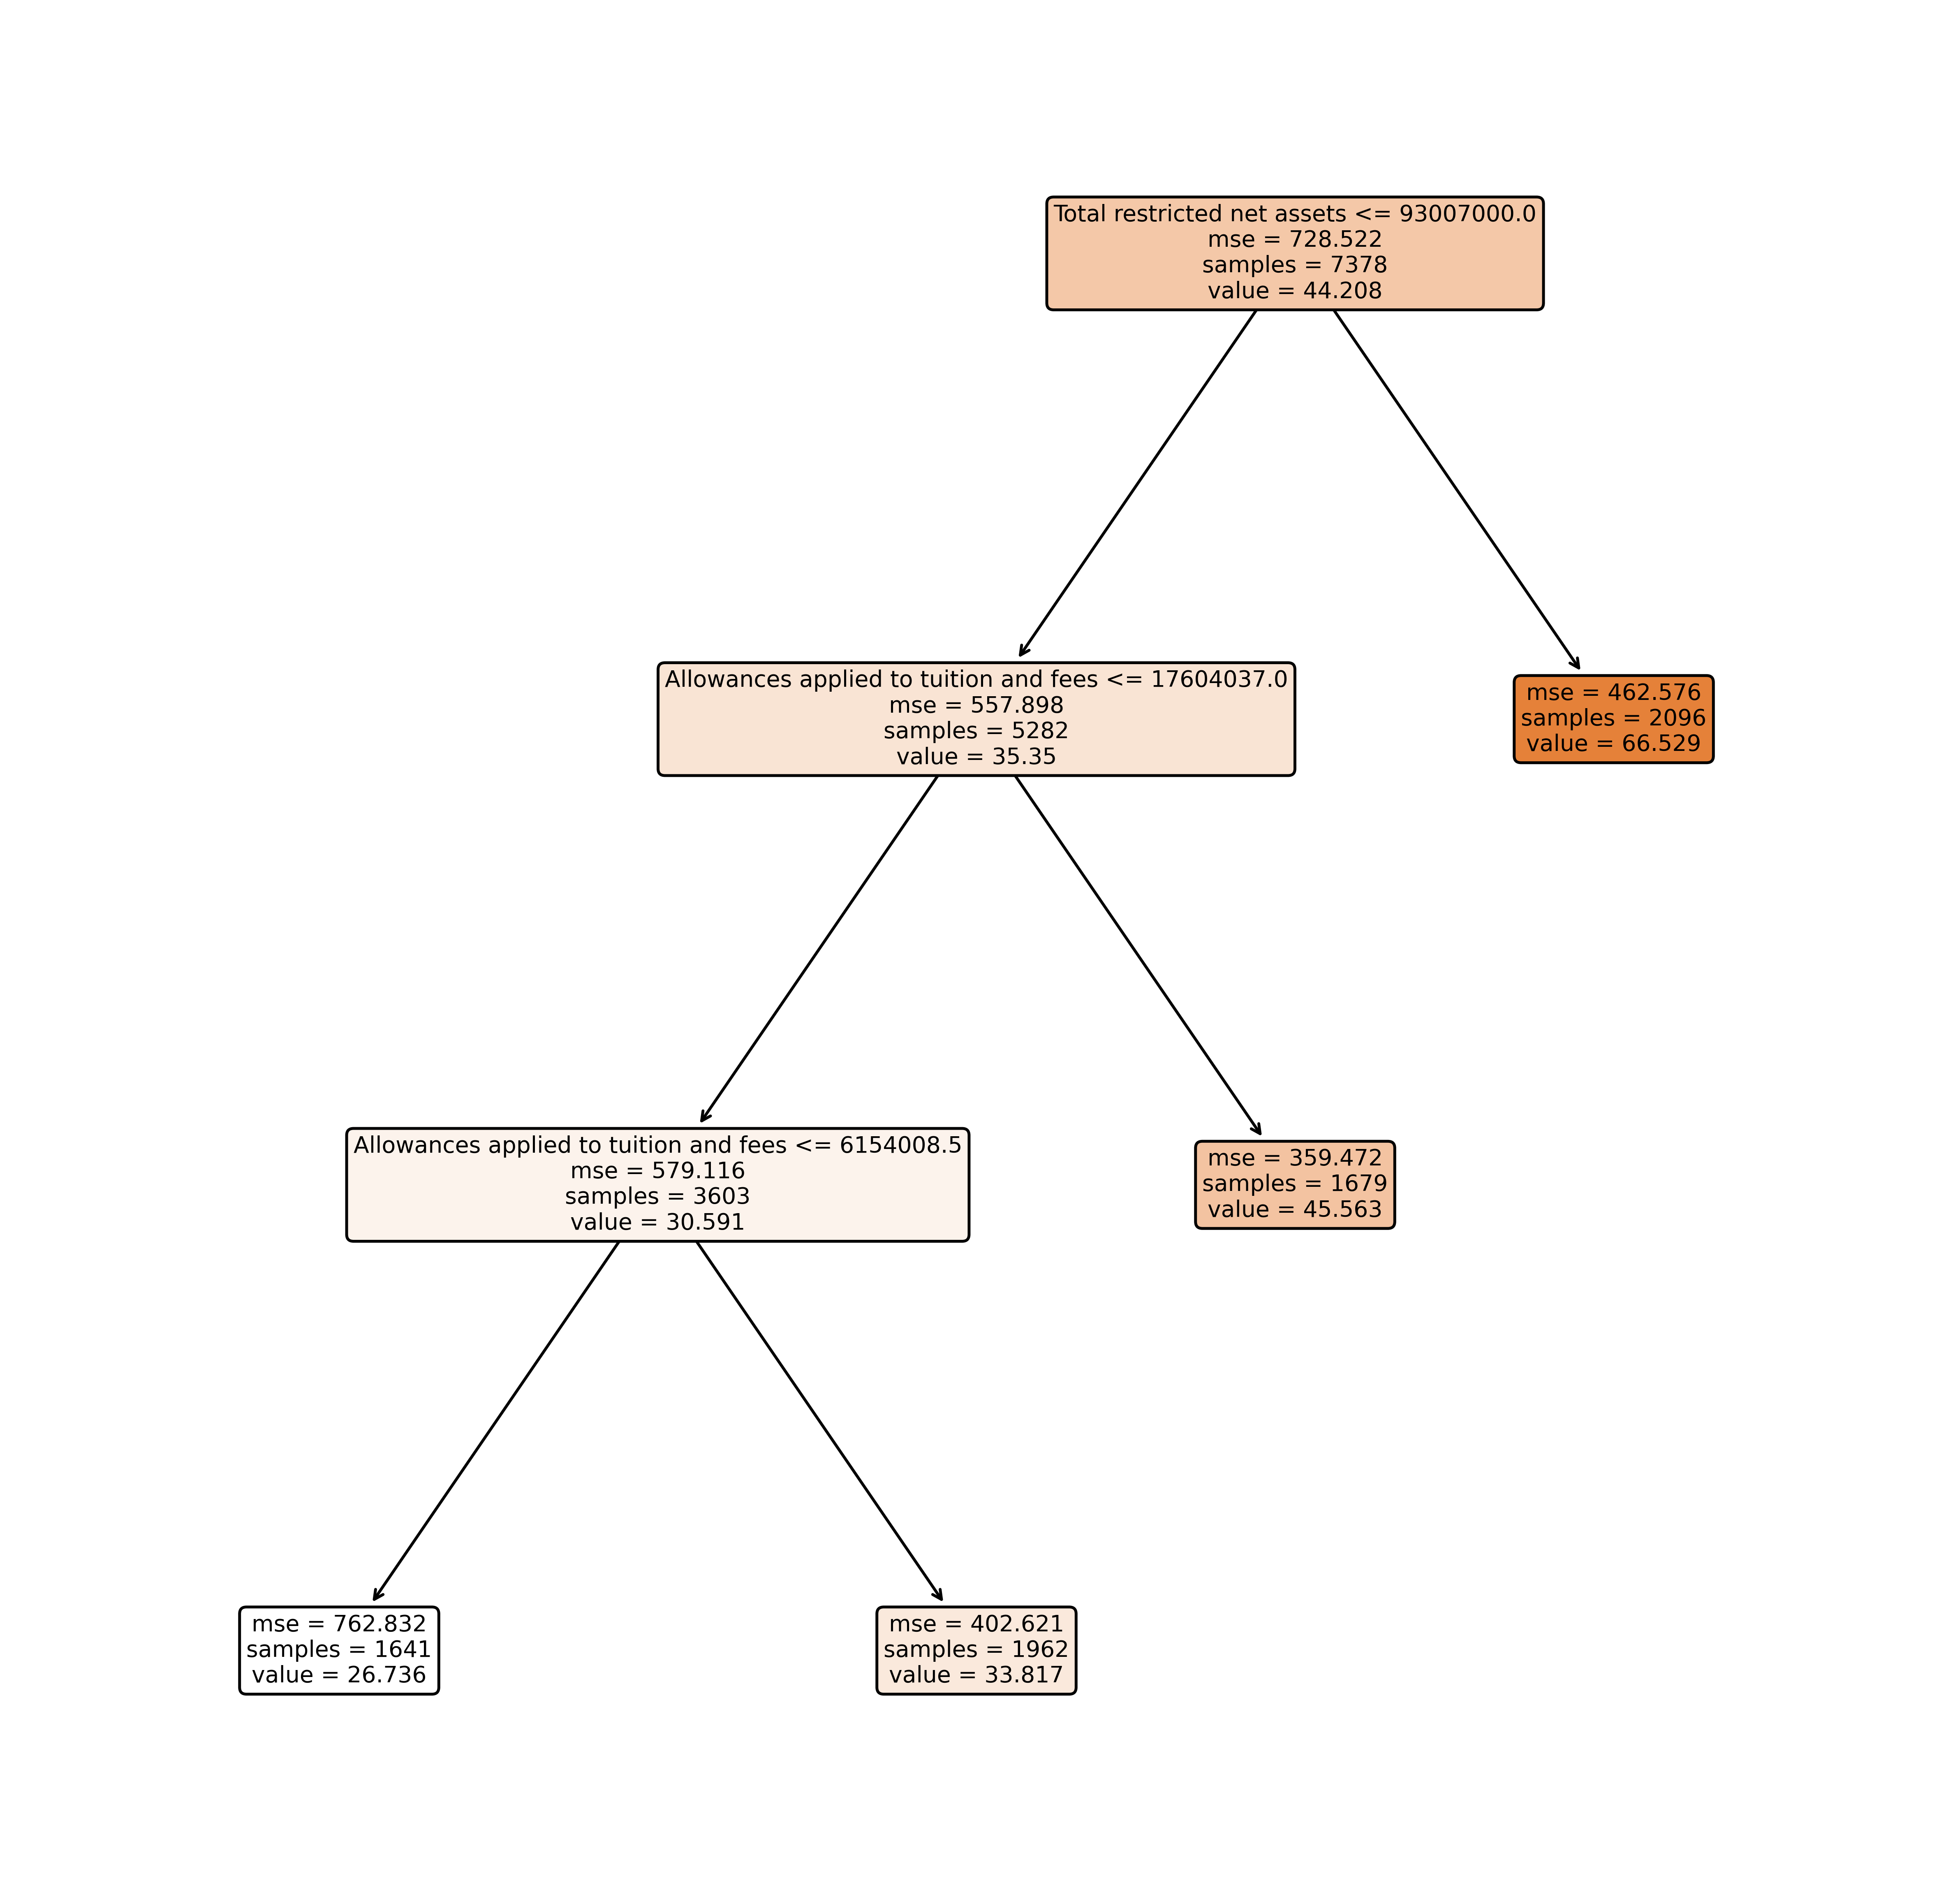

In [46]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
plot_tree(separate_tree_pr, 
               feature_names=selected_feat_pr.columns,
               class_names=np.unique(y_train_pr).astype('str'),
               filled=True, rounded=True)
plt.show()


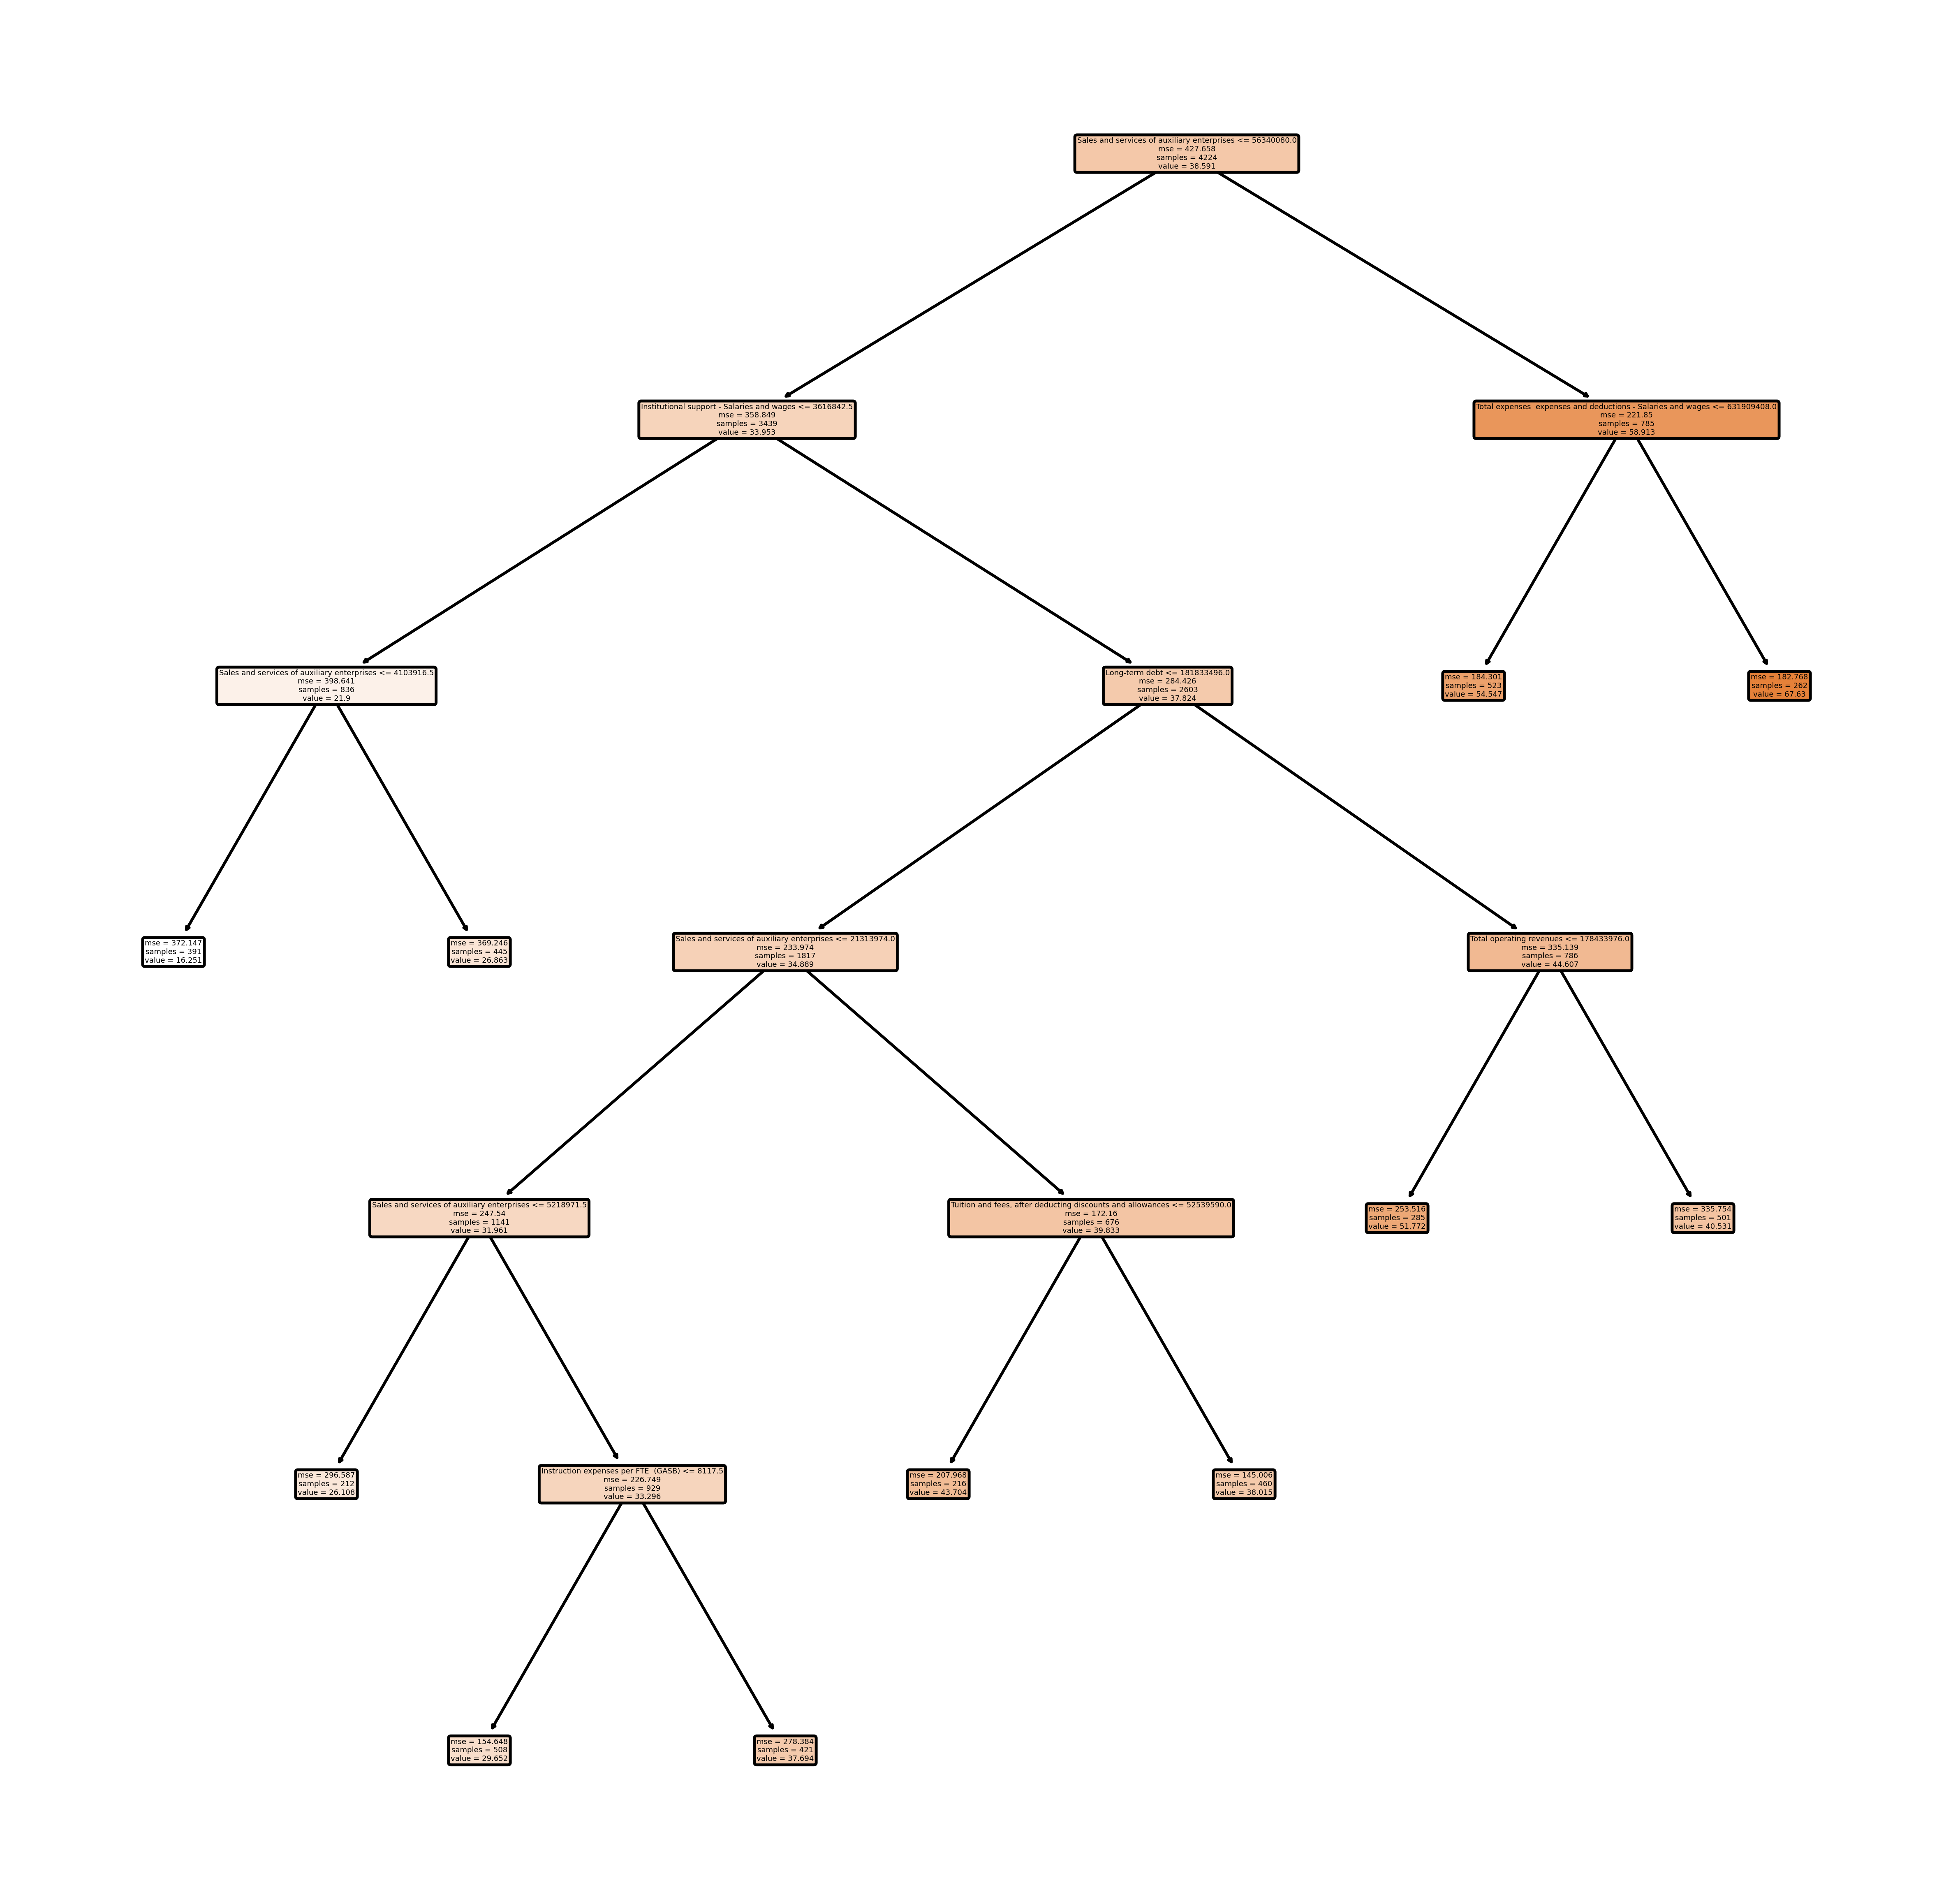

In [47]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
plot_tree(separate_tree_pub, 
               feature_names=selected_feat_pub.columns,
               class_names=np.unique(y_train_pub).astype('str'),
               filled=True, rounded=True)
plt.show()


In [48]:
#Feature Importance
important_private = []
names_private = []
for name, importance in zip(X_train_pr.columns, tree_pr['tree'].feature_importances_):
    if importance > 0:
        important_private.append((name, importance))
        names_private.append(name)

print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[:10])

[('Total liabilities', 0.8233125032610025), ('Other plant, property and equipment', 0.14552816568084112), ('Accumulated depreciation', 0.016634310697701635), ('Net assets, end of the year', 0.009793850379123179), ('Construction in Progress', 0.004731169981331627)]


In [49]:
#Feature importance for Public
important_public = []
names_public = []
for name, importance in zip(X_train_pub.columns, tree_pub['tree'].feature_importances_):
    if importance > 0:
        important_public.append((name, importance))
        names_public.append(name)
print(sorted(important_public, key=lambda tup: tup[1], reverse=True)[:10])

[('Total noncurrent assets', 0.6154001006451292), ('Restricted-expendable', 0.25916989659768164), ('UNITID', 0.06978926394735308), ('Total assets ', 0.030920478881475085), ('Buildings - Ending balance', 0.013259263776514133), ('Other noncurrent liabilities ', 0.008016485323686984), ('Other noncurrent assets', 0.003444510828159896)]



### TESTS

#### Preprocessing

In [50]:
#Private
si=SimpleImputer()
X_test_pr_imputed= si.fit_transform(X_test_pr, y_test_pr)
X_test_pr_imputed=pd.DataFrame(X_test_pr_imputed, 
    index=X_test_pr.index, columns=X_test_pr.columns)
#feature Selection
sel_pr= SelectFromModel(RandomForestRegressor(max_features=24, n_estimators=100, max_depth=7, 
                                    min_samples_split=.1, min_samples_leaf=.1))
sel_pr.fit(X_test_pr_imputed,y_test_pr)
#get column names
selected_feat_pr_test= X_test_pr_imputed.columns[(sel_pr.get_support())]
#change index to list
selected_feat_pr_test = selected_feat_pr_test.tolist()
#slide dataframe
selected_feat_pr_test=X_test_pr_imputed[selected_feat_pr_test]


In [51]:
#Public
si = SimpleImputer()
X_test_pub_imputed= si.fit_transform(X_test_pub, y_test_pub)
X_test_pub_imputed=pd.DataFrame(X_test_pub_imputed, 
    index=X_test_pub.index, columns=X_test_pub.columns)
sel_pub= SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6, random_state=42))
sel_pub.fit(X_test_pub_imputed, y_test_pub)
selected_feat_pub_test= X_test_pub_imputed.columns[(sel_pub.get_support())]
selected_feat_pub_test = selected_feat_pub_test.tolist()
selected_feat_pub_test=X_test_pub_imputed[selected_feat_pub_test]

#### Model

In [52]:
#private
separate_tree_pr_preds =separate_tree_pr.predict(selected_feat_pr)
separate_tree_pr_score= separate_tree_pr.score(selected_feat_pr, y_test_pr)
print("Test Tree PR R^2:" + str(separate_tree_pr_score))
separate_tree_pr_rmse = np.sqrt(mean_squared_error(y_test_pr,separate_tree_pr_preds))
print('Test Tree PR Root Mean Squared Error:' +str(separate_tree_pr_rmse))

ValueError: Found input variables with inconsistent numbers of samples: [2460, 7378]

In [ ]:
#Public
separate_tree_pub_preds =separate_tree_pub.predict(selected_feat_pub)
separate_tree_pub_score= separate_tree_pub.score(selected_feat_pub, y_test_pub)
print("Test Tree PUB R^2:" + str(separate_tree_pub_score))
separate_tree_pub_rmse = np.sqrt(mean_squared_error(y_test_pub,separate_tree_pub_preds))
print('Test Tree PUB Root Mean Squared Error:' + str(separate_tree_pub_rmse))

# Recommendations

# Next Steps
The graduation rate for IPEDS only calculates first time, full-time students, which excludes transfers,  winter enrollment, and part-timers, possibly [up to 50% of students](). 